# TGFB3


In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


### TGFB3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFB3.

In [2]:
gene_symbol = 'TGFB3'
mane_tx_id = 'NM_003239.5'
mane_protein_id = 'NP_003230.1' # transforming growth factor beta-3 proprotein isoform 1 preproprotein [Homo sapiens]

In [13]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)

from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/TGFB3/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
phenopackets = ingestor.get_phenopacket_list()



cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 43 phenopackets
[pyphetools] Ingested 75 GA4GH phenopackets.
Individuals Processed: 100%|██████████| 75/75 [00:17<00:00,  4.33individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Aortic root aneurysm,HP:0002616,19
Arachnodactyly,HP:0001166,16
Tall stature,HP:0000098,15
Hypertelorism,HP:0000316,14
Bifid uvula,HP:0000193,12
Retrognathia,HP:0000278,9
Scoliosis,HP:0002650,9
Joint hypermobility,HP:0001382,8
Ascending aortic dissection,HP:0004933,6
Cleft palate,HP:0000175,6


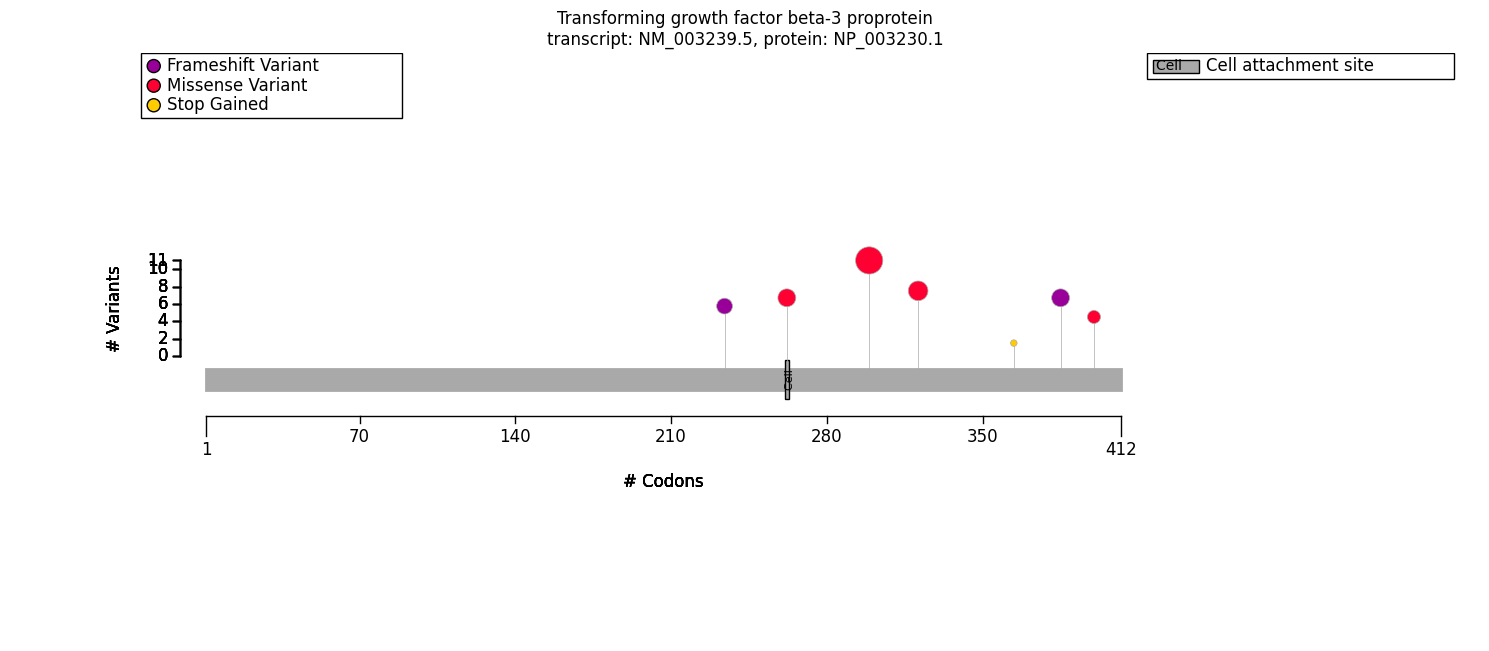

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Cell attachment site,MOTIF,261 - 263,4,p.Asp263His


# Strategy
todo

In [7]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

is_Asp263His = VariantPredicates.variant_key(key="14_75963455_75963455_C_G") #	c.787G>C	p.Asp263His

gt_predicate = autosomal_dominant(is_Asp263His)
gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [9]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,14
HMF02,Skipping term because no genotype has more than one observed HPO count,2
HMF04,Skipping term because all genotypes have same HPO observed proportions,16
HMF05,Skipping term because one genotype had zero observations,18
HMF06,Skipping term with less than 7 observations (not powered for 2x2),46
HMF08,Skipping general term,42


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group               HOM_REF           HET          \
                                           Count Percent Count Percent   
Ascending aortic dissection [HP:0004933]    5/39     13%   1/4     25%   
Scoliosis [HP:0002650]                      9/39     23%   0/4      0%   
Aortic root aneurysm [HP:0002616]          16/24     67%   3/4     75%   
Mitral valve prolapse [HP:0001634]          5/24     21%   0/4      0%   
Bruising susceptibility [HP:0000978]        4/19     21%   0/4      0%   

What is the genotype group                                             
                                         Corrected p values  p values  
Ascending aortic dissection [HP:0004933]                1.0  0.464833  
Scoliosis [HP:0002650]                                  1.0  0.563601  
Aortic root aneurysm [HP:0002616]                       1.0  1.000000  
Mitral valve prolapse [HP:0001634]                      1.0  1.000000  
Bruising susceptibility [HP:0000978]                    1.0  1.000000

In [11]:

from gpsea.model import VariantEffect
missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(missense)
gt_predicate.display_question()
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group           HOM_REF            HET          \
                                       Count Percent  Count Percent   
Cleft palate [HP:0000175]                2/2    100%   4/10     40%   
Scoliosis [HP:0002650]                  3/21     14%   6/22     27%   
Dermal translucency [HP:0010648]        1/13      8%    2/8     25%   
Mitral valve prolapse [HP:0001634]      4/18     22%   1/10     10%   
Arachnodactyly [HP:0001166]              5/6     83%  11/16     69%   
Aortic root aneurysm [HP:0002616]       9/12     75%  10/16     62%   
Tall stature [HP:0000098]               9/15     60%   6/12     50%   
Hypertelorism [HP:0000316]               2/2    100%  12/14     86%   
Joint hypermobility [HP:0001382]         1/1    100%   7/11     64%   
Bifid uvula [HP:0000193]                 2/2    100%  10/12     83%   
Bruising susceptibility [HP:0000978]    3/14     21%    1/9     11%   

What is the genotype group                                         
                                     Corrected p values  p values  
Cleft palate [HP:0000175]                           1.0  0.454545  
Scoliosis [HP:0002650]                              1.0  0.456553  
Dermal translucency [HP:0010648]                    1.0  0.530827  
Mitral valve prolapse [HP:0001634]                  1.0  0.626374  
Arachnodactyly [HP:0001166]                         1.0  0.634112  
Aortic root aneurysm [HP:0002616]                   1.0  0.686957  
Tall stature [HP:0000098]                           1.0  0.706825  
Hypertelorism [HP:0000316]                          1.0  1.000000  
Joint hypermobility [HP:0001382]                    1.0  1.000000  
Bifid uvula [HP:0000193]                            1.0  1.000000  
Bruising susceptibility [HP:0000978]                1.0  1.000000

In [12]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex of the individual                           FEMALE           MALE          \
                                                 Count Percent  Count Percent   
Bruising susceptibility [HP:0000978]              4/11     36%   0/12      0%   
Mitral valve prolapse [HP:0001634]                0/13      0%   5/15     33%   
Dermal translucency [HP:0010648]                  3/10     30%   0/11      0%   
Ascending aortic dissection [HP:0004933]          1/20      5%   5/23     22%   
Aortic root aneurysm [HP:0002616]                 7/13     54%  12/15     80%   
Tall stature [HP:0000098]                         5/12     42%  10/15     67%   
Bifid uvula [HP:0000193]                           7/7    100%    5/7     71%   
Scoliosis [HP:0002650]                            3/20     15%   6/23     26%   
Descending thoracic aorta aneurysm [HP:0004959]    0/5      0%    2/8     25%   
Joint hypermobility [HP:0001382]                   6/8     75%    2/4     50%   
Cleft palate [HP:0000175]                          2/6     33%    4/6     67%   
Arachnodactyly [HP:0001166]                       8/12     67%   8/10     80%   
Hypertelorism [HP:0000316]                         6/7     86%    8/9     89%   

Sex of the individual                                                         
                                                Corrected p values  p values  
Bruising susceptibility [HP:0000978]                      0.283730  0.037267  
Mitral valve prolapse [HP:0001634]                        0.283730  0.043651  
Dermal translucency [HP:0010648]                          0.390977  0.090226  
Ascending aortic dissection [HP:0004933]                  0.558048  0.191797  
Aortic root aneurysm [HP:0002616]                         0.558048  0.227536  
Tall stature [HP:0000098]                                 0.558048  0.257560  
Bifid uvula [HP:0000193]                                  0.670209  0.461538  
Scoliosis [HP:0002650]                                    0.670209  0.467449  
Descending thoracic aorta aneurysm [HP:0004959]           0.670209  0.487179  
Joint hypermobility [HP:0001382]                          0.670209  0.547475  
Cleft palate [HP:0000175]                                 0.670209  0.567100  
Arachnodactyly [HP:0001166]                               0.700022  0.646174  
Hypertelorism [HP:0000316]                                1.000000  1.000000

# Summary
We found no evidence for genotype-phenotype correlations.